Autoencoders for Anomaly Detection

## Step 1: Data preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary


In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [7]:
#Loading the dataset
df = pd.read_csv("nyc_taxi.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [8]:
print("Head of half-hourly data:")
print(df.head())
print("\nNumber of samples (time points):", len(df))
print("Number of features:", df.shape[1])
stats = df.describe()
print("\nDescriptive Statistics:\n", stats)

Head of half-hourly data:
                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820

Number of samples (time points): 10320
Number of features: 1

Descriptive Statistics:
               value
count  10320.000000
mean   15137.569380
std     6939.495808
min        8.000000
25%    10262.000000
50%    16778.000000
75%    19838.750000
max    39197.000000


<span style='color:green'> The dataset consists of the number of taxi rides taken in New York City, recorded in 30-minute intervals. It is taken from the Numenta Anomaly Benchmark (NAB)[https://www.kaggle.com/datasets/boltzmannbrain/nab]. The key variable is value, which is the number of rides at each timestamp and timestamp provides the temporal context for each observation. </span>

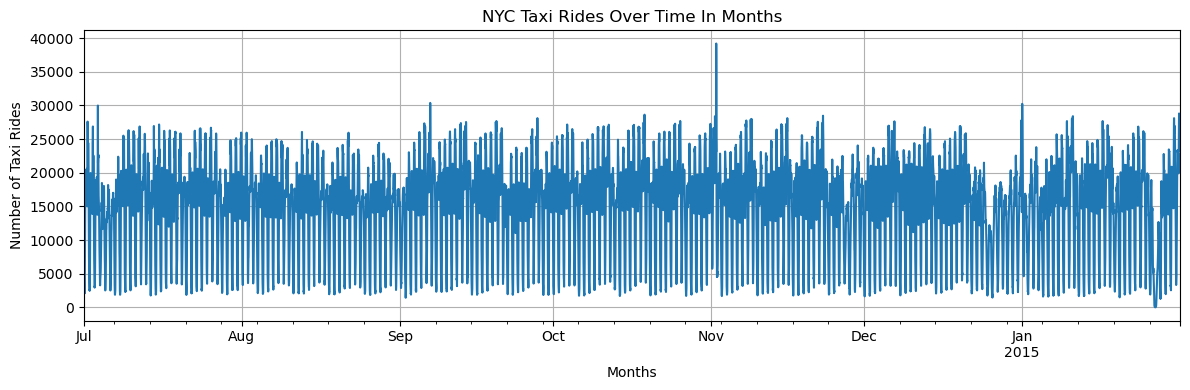

In [10]:
plt.figure(figsize=(12, 4))
df['value'].plot()
plt.title('NYC Taxi Rides Over Time In Months')
plt.xlabel('Months')
plt.ylabel('Number of Taxi Rides')
plt.grid(True)
plt.tight_layout()
plt.show()

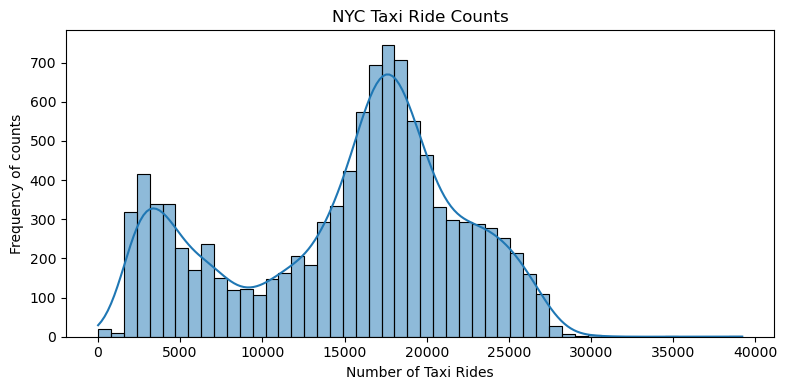

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(df['value'], bins=50, kde=True)
plt.title('NYC Taxi Ride Counts')
plt.xlabel('Number of Taxi Rides')
plt.ylabel('Frequency of counts')
plt.tight_layout()
plt.show()

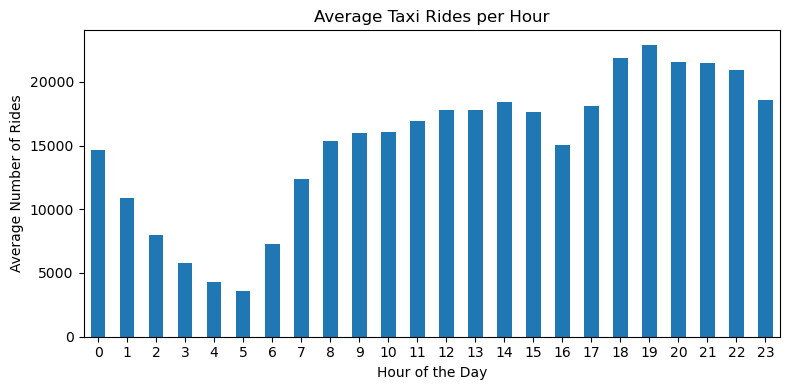

In [12]:
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['value'].mean()

plt.figure(figsize=(8, 4))
hourly_avg.plot(kind='bar')
plt.title('Average Taxi Rides per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Rides')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
missingValues = df.isnull().sum()
print(missingValues)

value    0
hour     0
dtype: int64


In [14]:
scaler = MinMaxScaler()
df["normalized_value"] = scaler.fit_transform(df[["value"]])

In [15]:
def createSequences(values, seq_len):
    X_list = []
    for i in range(len(values) - seq_len + 1):
        window = values[i : i+seq_len]
        X_list.append(window)
    return np.array(X_list)

df.sort_index(inplace=True)
valuesArray = df["normalized_value"].values
X_seq = createSequences(valuesArray, 48)
print("Created sequences shape:", X_seq.shape)

Created sequences shape: (10273, 48)


In [16]:
#Creating time based splits considering 48 step windows
N = len(X_seq)
train_ending = int(0.7 * N)
val_ending   = int(0.9 * N)

X_train = X_seq[:train_ending]
X_val   = X_seq[train_ending:val_ending]
X_test  = X_seq[val_ending:]

print(f"Train size: {X_train.shape[0]} sequences")
print(f"Val size:   {X_val.shape[0]} sequences")
print(f"Test size:  {X_test.shape[0]} sequences")

Train size: 7191 sequences
Val size:   2054 sequences
Test size:  1028 sequences


In [86]:
X_traintensor = torch.tensor(X_train, dtype=torch.float32)
X_valtensor   = torch.tensor(X_val,   dtype=torch.float32)
X_testtensor  = torch.tensor(X_test,  dtype=torch.float32)

batch_size = 16
trainLoader = DataLoader(TensorDataset(X_traintensor), batch_size=batch_size, shuffle=False)
valLoader   = DataLoader(TensorDataset(X_valtensor),   batch_size=batch_size, shuffle=False)
testLoader  = DataLoader(TensorDataset(X_testtensor),  batch_size=batch_size, shuffle=False)

In [87]:
df.head()

,value,hour,normalized_value
timestamp,,,
2014-07-01 00:00:00,10844,0,0.276506
2014-07-01 00:30:00,8127,0,0.207175
2014-07-01 01:00:00,6210,1,0.158259
2014-07-01 01:30:00,4656,1,0.118605
2014-07-01 02:00:00,3820,2,0.097272


## Step 2: Autoencoder model building

### Model 1 Architecture ###

In [88]:
class DenseAutoencoder(nn.Module):
    def __init__(self, input_dim=48):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

denseAutoencoder = DenseAutoencoder(48).to(device)
summary(denseAutoencoder, input_size=(batch_size, 48))

Layer (type:depth-idx)                   Output Shape              Param #
DenseAutoencoder                         [16, 48]                  --
├─Sequential: 1-1                        [16, 16]                  --
│    └─Linear: 2-1                       [16, 64]                  3,136
│    └─ReLU: 2-2                         [16, 64]                  --
│    └─Linear: 2-3                       [16, 32]                  2,080
│    └─ReLU: 2-4                         [16, 32]                  --
│    └─Linear: 2-5                       [16, 16]                  528
│    └─ReLU: 2-6                         [16, 16]                  --
├─Sequential: 1-2                        [16, 48]                  --
│    └─Linear: 2-7                       [16, 32]                  544
│    └─ReLU: 2-8                         [16, 32]                  --
│    └─Linear: 2-9                       [16, 64]                  2,112
│    └─ReLU: 2-10                        [16, 64]                  --
│   

### Model 2 Architecture ###

In [89]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(input_size=hidden_dim, hidden_size=input_dim, batch_first=True)

    def forward(self, x):
        encoded_seq, _ = self.encoder(x)
        decoded_seq, _ = self.decoder(encoded_seq)
        return decoded_seq

lstmAutoencoder = LSTMAutoencoder(input_dim=1, hidden_dim=16).to(device)
summary(lstmAutoencoder, input_size=(batch_size, 48, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMAutoencoder                          [16, 48, 1]               --
├─LSTM: 1-1                              [16, 48, 16]              1,216
├─LSTM: 1-2                              [16, 48, 1]               76
Total params: 1,292
Trainable params: 1,292
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.01
Estimated Total Size (MB): 0.11

### Model 3 Architecture ###

In [90]:
class Conv1DAutoencoder(nn.Module):
    def __init__(self):
        super(Conv1DAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

convAutoencoder = Conv1DAutoencoder().to(device)
summary(convAutoencoder, input_size=(batch_size, 1, 48))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DAutoencoder                        [16, 1, 48]               --
├─Sequential: 1-1                        [16, 8, 48]               --
│    └─Conv1d: 2-1                       [16, 16, 48]              64
│    └─ReLU: 2-2                         [16, 16, 48]              --
│    └─Conv1d: 2-3                       [16, 8, 48]               392
│    └─ReLU: 2-4                         [16, 8, 48]               --
├─Sequential: 1-2                        [16, 1, 48]               --
│    └─ConvTranspose1d: 2-5              [16, 16, 48]              400
│    └─ReLU: 2-6                         [16, 16, 48]              --
│    └─ConvTranspose1d: 2-7              [16, 1, 48]               49
Total params: 905
Trainable params: 905
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.70
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.00
Estimated Total Size (MB): 0.26

In [91]:
def trainAutoencoder(model, train_loader, val_loader, model_type="dense", epochs=10, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for (batch,) in train_loader:
            batch = batch.to(device)

            if model_type == "conv":
                batch_in = batch.unsqueeze(1)
            elif model_type == "lstm":
                batch_in = batch.unsqueeze(-1)
            else:
                batch_in = batch

            optimizer.zero_grad()
            outputs = model(batch_in)

            if model_type == "conv":
                outputs = outputs.squeeze(1)
            elif model_type == "lstm":
                outputs = outputs.squeeze(-1)           

            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for (batch,) in val_loader:
                batch = batch.to(device)
                if model_type == "lstm":
                    batch_in = batch.unsqueeze(-1)
                elif model_type == "conv":
                    batch_in = batch.unsqueeze(1)
                else:
                    batch_in = batch

                val_out = model(batch_in)
                if model_type == "lstm":
                    val_out = val_out.squeeze(-1)
                elif model_type == "conv":
                    val_out = val_out.squeeze(1)

                val_loss = criterion(val_out, batch)
                running_val_loss += val_loss.item()

        val_losses.append(running_val_loss / len(val_loader))
        print(f"Epoch [{epoch+1}] for {model_type} | "
              f"Train Loss is {train_losses[-1]:.4f}, Val Loss is {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [92]:
def trainAndSelectBest(models, model_names, model_types, train_loader, val_loader, epochs=10, lr = 0.001):
    best_model = None
    best_model_name = None
    best_val_loss = float('inf')
    all_history = {}

    for model, name, mtype in zip(models, model_names, model_types):
        print(f"\n Training for  {name} ")
        t_losses, v_losses = trainAutoencoder(model, train_loader, val_loader,
                                               model_type=mtype, epochs=epochs, lr=lr)
        all_history[name] = (t_losses, v_losses)
        final_val = v_losses[-1]
        if final_val < best_val_loss:
            best_val_loss = final_val
            best_model = model
            best_model_name = name

    print(f"\nBest Model: {best_model_name} with Val Loss: {best_val_loss:.4f}")
    return best_model, best_model_name, all_history


In [93]:
dense_model   = DenseAutoencoder(48).to(device)
lstm_model    = LSTMAutoencoder(1, hidden_dim=16).to(device)
conv_model    = Conv1DAutoencoder().to(device)

models_list   = [dense_model, lstm_model, conv_model]
names_list    = ["DenseAE","LSTMAE","Conv1DAE"]
types_list    = ["dense","lstm","conv"]

best_model, best_model_name, history = trainAndSelectBest(models_list, names_list, types_list,trainLoader, valLoader,epochs=10, lr=0.0001)



 Training for  DenseAE 
Epoch [1] for dense | Train Loss is 0.0667, Val Loss is 0.0275
Epoch [2] for dense | Train Loss is 0.0287, Val Loss is 0.0272
Epoch [3] for dense | Train Loss is 0.0276, Val Loss is 0.0243
Epoch [4] for dense | Train Loss is 0.0223, Val Loss is 0.0192
Epoch [5] for dense | Train Loss is 0.0186, Val Loss is 0.0155
Epoch [6] for dense | Train Loss is 0.0127, Val Loss is 0.0092
Epoch [7] for dense | Train Loss is 0.0083, Val Loss is 0.0068
Epoch [8] for dense | Train Loss is 0.0058, Val Loss is 0.0053
Epoch [9] for dense | Train Loss is 0.0043, Val Loss is 0.0046
Epoch [10] for dense | Train Loss is 0.0037, Val Loss is 0.0042

 Training for  LSTMAE 
Epoch [1] for lstm | Train Loss is 0.5630, Val Loss is 0.1090
Epoch [2] for lstm | Train Loss is 0.0734, Val Loss is 0.0477
Epoch [3] for lstm | Train Loss is 0.0476, Val Loss is 0.0439
Epoch [4] for lstm | Train Loss is 0.0432, Val Loss is 0.0401
Epoch [5] for lstm | Train Loss is 0.0393, Val Loss is 0.0365
Epoch [6] 

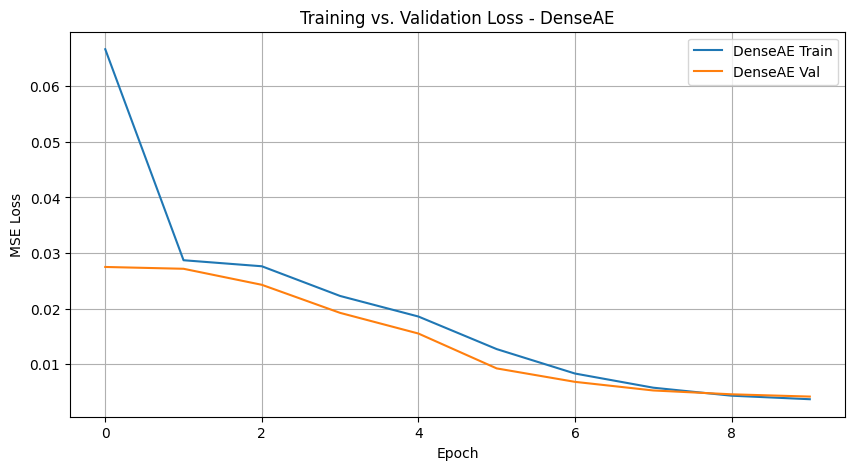

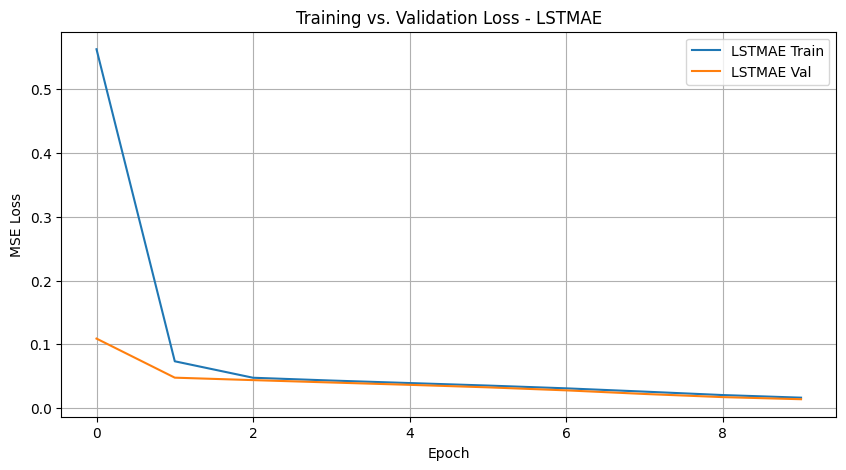

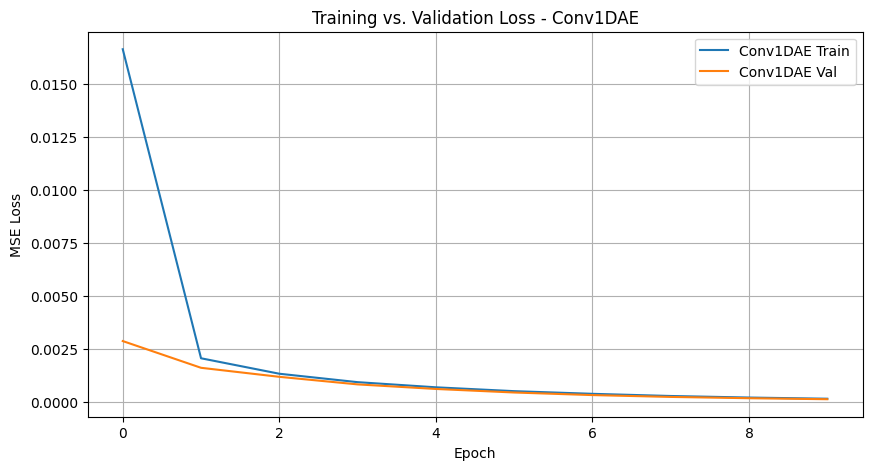

In [94]:
def plotAllLossCurves(history_dict):
    for model_name, (train_losses, val_losses) in history_dict.items():
        plt.figure(figsize=(10,5))
        x_epochs = range(len(train_losses))
        plt.plot(x_epochs, train_losses, label=f"{model_name} Train")
        plt.plot(x_epochs, val_losses, label=f"{model_name} Val")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title(f"Training vs. Validation Loss - {model_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

plotAllLossCurves(history)

## Step 3: Evaluation and analysis

In [96]:


def evaluateOnTest(model, model_name, model_type, test_loader):
    model.eval()
    criterion = nn.MSELoss()
    test_losses = []
    all_true = []
    all_pred = []

    with torch.no_grad():
        for (batch,) in test_loader:
            batch = batch.to(device)
            if model_type == "lstm":
                batch_in = batch.unsqueeze(-1)
            elif model_type == "conv":
                batch_in = batch.unsqueeze(1)
            else:
                batch_in = batch

            out = model(batch_in)
            if model_type == "lstm":
                out = out.squeeze(-1)
            elif model_type == "conv":
                out = out.squeeze(1)

            loss_val = criterion(out, batch).item()
            test_losses.append(loss_val)

            all_true.append(batch.cpu().numpy())
            all_pred.append(out.cpu().numpy())

    avg_test_loss = np.mean(test_losses)
    print(f"TEST RESULTS for {model_name}")
    print(f"Test Loss (MSE): {avg_test_loss:.4f}")

    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    print(f"Test Losses for {best_model_name}: {avg_test_loss}")
    return avg_test_loss, all_true, all_pred



In [97]:
if best_model_name == "DenseAE":
    best_type = "dense"
elif best_model_name == "LSTMAE":
    best_type = "lstm"
else:
    best_type = "conv"

avg_test_loss, all_true, all_pred = evaluateOnTest(best_model, best_model_name, best_type, testLoader)

TEST RESULTS for Conv1DAE
Test Loss (MSE): 0.0001
Test Losses for Conv1DAE: 0.00014408533338260336


In [98]:
best_model_train_loss, best_model_val_loss = history[best_model_name]
print(f"Training Losses for {best_model_name}: {best_model_train_loss}")
print(f"Validation Losses for {best_model_name}: {best_model_val_loss}")

Training Losses for Conv1DAE: [0.016631176244053577, 0.0020555650462241223, 0.0013261333022577067, 0.0009290758024629516, 0.0006863053869650078, 0.0005046653846511617, 0.00037915245890164645, 0.000276543296786258, 0.00020344246000200252, 0.00014770718042402426]
Validation Losses for Conv1DAE: [0.002867282066826326, 0.001606036483196455, 0.0011807164423665855, 0.0008238304810022733, 0.0006082588194214284, 0.0004412140391537804, 0.0003194345401368977, 0.00023241876139460752, 0.00017172360150666922, 0.00012426086393606402]


In [99]:
def calculateRegressionMetrics(all_true, all_pred):
    mae_val = mean_absolute_error(all_true, all_pred)
    rmse_val = np.sqrt(mean_squared_error(all_true, all_pred))
    r2_val = r2_score(all_true, all_pred)

    print(f"MAE: {mae_val:.4f}")
    print(f"RMSE: {rmse_val:.4f}")
    print(f"R^2: {r2_val:.4f}")

    return mae_val, rmse_val, r2_val

calculateRegressionMetrics(all_true, all_pred)


MAE: 0.0068
RMSE: 0.0119
R^2: 0.9961


(0.006811954081058502, np.float64(0.01190482065970702), 0.9961394667625427)

In [100]:
def plotLossCurves(history_dict, best_model_name):
    for model_name, (train_losses, val_losses) in history_dict.items():
        if model_name == best_model_name:
            plt.figure(figsize=(10,5))
            x_epochs = range(len(train_losses))
            plt.plot(x_epochs, train_losses, label=f"{model_name} Train")
            plt.plot(x_epochs, val_losses, label=f"{model_name} Val")
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.title(f"Training vs. Validation Loss - {model_name}")
            plt.legend()
            plt.grid(True)
            plt.show()


In [101]:
def plotReconstructionError(all_true, all_pred, model_name, y_zoom_factor=0.1):
    recon_errors = (all_true - all_pred) ** 2
    recon_errors = recon_errors.flatten()

    plt.figure(figsize=(8, 6))
    sns.histplot(recon_errors, kde=True)

    max_error = np.max(recon_errors)
    plt.xlim(0,max_error)
    
    max_freq = plt.gca().get_ylim()[1]
    plt.ylim(0, min(max_freq, y_zoom_factor * max_freq))

    mean_err = np.mean(recon_errors)
    std_err = np.std(recon_errors)

    threshold = mean_err + 3 * std_err
    anomalies = recon_errors > threshold

    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (3-Sigma) = {threshold:.4f}')

    plt.xlabel("Reconstruction Error (MSE per element)")
    plt.ylabel("Frequency")
    plt.title(f"Reconstruction Error Distribution - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n3-Sigma Rule: threshold={threshold:.6f}")
    print(f"Number of anomalies found: {np.sum(anomalies)} out of {len(recon_errors)}")


In [102]:
def plotTestLossBestModel(avg_test_loss,best_model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(range(10),[avg_test_loss] * 10, label=f'{best_model_name} Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss (MSE)")
    plt.title(f"Test Loss Plot for {best_model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

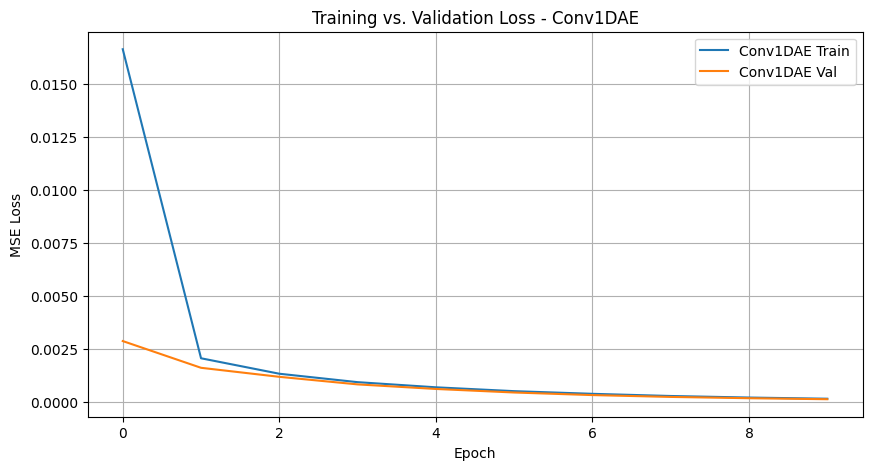

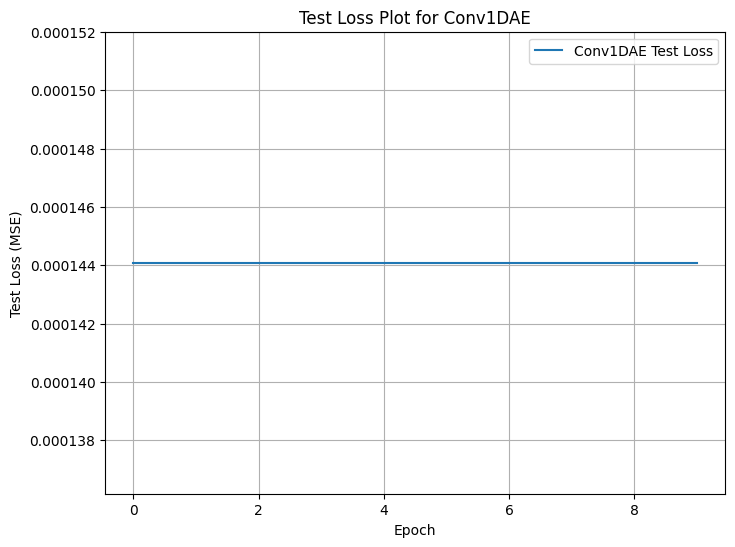

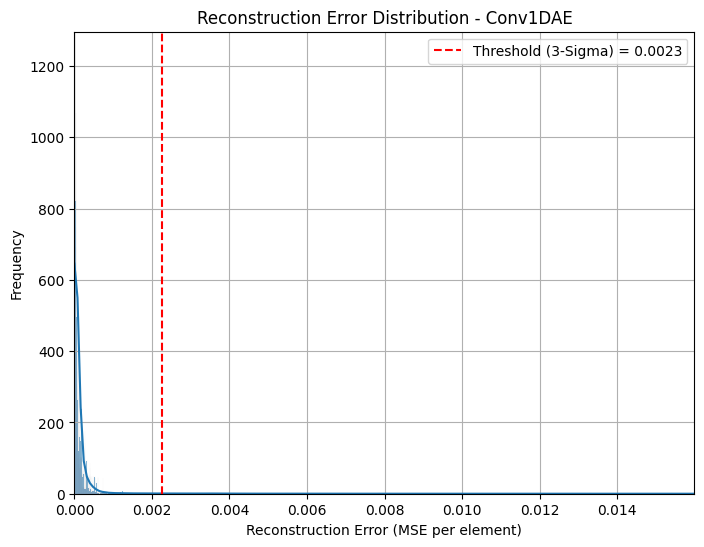


3-Sigma Rule: threshold=0.002259
Number of anomalies found: 639 out of 49344


In [103]:

plotLossCurves(history, best_model_name)
plotTestLossBestModel(avg_test_loss,best_model_name)
plotReconstructionError(all_true, all_pred, best_model_name)